In [1]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
from itertools import product

# 3D visualization with interactive plots
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

    
from Matrix_methods.Simulate import simulate_parallel, simulate_reference
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor, gen_loss_function
from Matrix_methods.AdamExtractor import LayeredExtractor

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n_values = [3.364, 2.522, 4.7]
k_values = [-0.000356, -0.003711, -0.001711]
d_values = [3.3e-05, 0.000179, 0.0001]

| Refractive Index | Absorption Coeff | Thickness [µm] |
|------------------|------------------|----------------|
|            3.364 |        -0.000356 |      3.300e-05 |
|            2.522 |        -0.003711 |      1.790e-04 |
|            4.700 |        -0.001711 |      1.000e-04 |
(Negative absorption coeff means loss in the material.)

Total Thickness: 312.0 µm


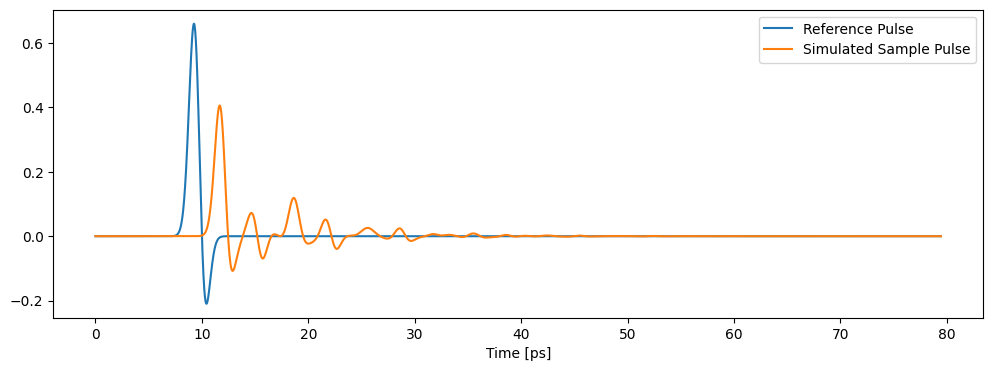

In [3]:
# Experimental material parameters (ground truth)
material_params_exp = [[(n_values[i] + 1j * k_values[i]), d_values[i]] for i in range(len(n_values))]


# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]


print("| Refractive Index | Absorption Coeff | Thickness [µm] |")
print("|------------------|------------------|----------------|")

for item in material_params_exp:
    n_real = np.real(item[0])
    n_imag = np.imag(item[0])
    thickness = item[1]
    print(f"| {n_real:16.3f} | {n_imag:16.6f} | {thickness:14.3e} |")

print('(Negative absorption coeff means loss in the material.)')

print(f'\nTotal Thickness: {sum(d_values) * 1e6} µm')

plt.figure(figsize=(12,4))
#plt.title(f'Simulated Time Domain of THz Pulse Passing Through a {len(n_values)} Layered Sample')
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Simulated Sample Pulse')
#plt.scatter(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), s=2, color= 'orange', label='Simulated Sample Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

In [4]:
# Define parameter limits and resolution
n_lims = [1.0, 5.0]
num_points = 50  # Reduced from 200 due to memory constraints (50^3 = 125,000 points)
# Fixed parameters
k1, k2, k3 = k_values  # Now need 3 extinction coefficients
d1, d2, d3 = d_values  # Now need 3 thicknesses

loss_fn = gen_loss_function

In [5]:

n1_vals = np.linspace(*n_lims, num_points)
n2_vals = np.linspace(*n_lims, num_points)
n3_vals = np.linspace(*n_lims, num_points)
n1_grid, n2_grid, n3_grid = np.meshgrid(n1_vals, n2_vals, n3_vals, indexing='ij')

loss_grid = np.zeros_like(n1_grid)
log_loss_grid = np.zeros_like(n1_grid)

print('Exploring 3-layer parameter space:')
print(f'Total evaluations: {n1_grid.size:,}')

for idx, (i, j, k) in enumerate(tqdm(product(range(num_points), repeat=3), 
                                     total=num_points**3, desc="Evaluating (n1, n2, n3) grid")):
    n1 = n1_grid[i, j, k]
    n2 = n2_grid[i, j, k]
    n3 = n3_grid[i, j, k]

    # Create complex refractive indices for all three layers
    layer = [(n1 + 1j * k1, d1), (n2 + 1j * k2, d2), (n3 + 1j * k3, d3)]

    y_sim = simulate_parallel(reference_pulse, layer, deltat, noise_level=0)[1][:len(reference_pulse)]
    y_sim_tensor = y_sim.clone().detach()

    loss = loss_fn(y_sim_tensor, experimental_pulse).item()
    loss_grid[i, j, k] = loss
    log_loss_grid[i, j, k] = np.log(loss)




Exploring 3-layer parameter space:
Total evaluations: 125,000


Evaluating (n1, n2, n3) grid: 100%|██████████| 125000/125000 [03:03<00:00, 682.64it/s]


In [6]:
# Find minimum loss point
min_idx = np.unravel_index(np.argmin(loss_grid), loss_grid.shape)
min_n1, min_n2, min_n3 = n1_grid[min_idx], n2_grid[min_idx], n3_grid[min_idx]

fig = go.Figure(data=go.Volume(
    x=n1_grid.flatten(),
    y=n2_grid.flatten(),
    z=n3_grid.flatten(),
    value=log_loss_grid.flatten(),
    opacity=0.2,
    surface_count=10,
    colorscale='Viridis'
))

fig.add_trace(go.Scatter3d(
    x=[n_values[0]], y=[n_values[1]], z=[n_values[2]],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='True (n1, n2, n3)'
))

fig.update_layout(
    title="3D Loss Landscape for 3-Layer Sample",
    scene=dict(
        xaxis_title="n1 (layer 1)",
        yaxis_title="n2 (layer 2)",
        zaxis_title="n3 (layer 3)"
    ),
    width=900,
    height=700,
)

fig.show()

In [7]:
# Sample points for visualization (use subset if data is too dense)
sample_indices = np.random.choice(n1_grid.size, size=15000, replace=False)  # Sample 5000 points
n1_flat = n1_grid.flatten()[sample_indices]
n2_flat = n2_grid.flatten()[sample_indices]
n3_flat = n3_grid.flatten()[sample_indices]
loss_flat = log_loss_grid.flatten()[sample_indices]

# Create the figure
fig = go.Figure()

# Add the main scatter plot
fig.add_trace(go.Scatter3d(
    x=n1_flat,
    y=n2_flat,
    z=n3_flat,
    mode='markers',
    marker=dict(
        size=2,
        color=loss_flat,
        colorscale='viridis',
        opacity=0.6,
        colorbar=dict(
            title="Log(Loss)",
            thickness=15,
            len=0.8
        )
    ),
    text=[f'n1: {n1:.2f}<br>n2: {n2:.2f}<br>n3: {n3:.2f}<br>Log(Loss): {loss:.2f}' 
            for n1, n2, n3, loss in zip(n1_flat, n2_flat, n3_flat, loss_flat)],
    hovertemplate='%{text}<extra></extra>',
    name='Loss Landscape'
))



fig.add_trace(go.Scatter3d(
    x=[n_values[0]], y=[n_values[1]], z=[n_values[2]],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='True (n1, n2, n3)'
))

# Update layout
fig.update_layout(
    title='3D Loss Landscape - Log(Loss)',
    scene=dict(
        xaxis_title='n1 (layer 1)',
        yaxis_title='n2 (layer 2)',
        zaxis_title='n3 (layer 3)',
        camera=dict(
            eye=dict(x=1.2, y=1.2, z=1.2)
        )
    ),
    width=900,
    height=700,
    showlegend=True
)

# Show the plot
fig.show()

# Optional: Save as HTML file
# fig.write_html("3d_loss_landscape.html")

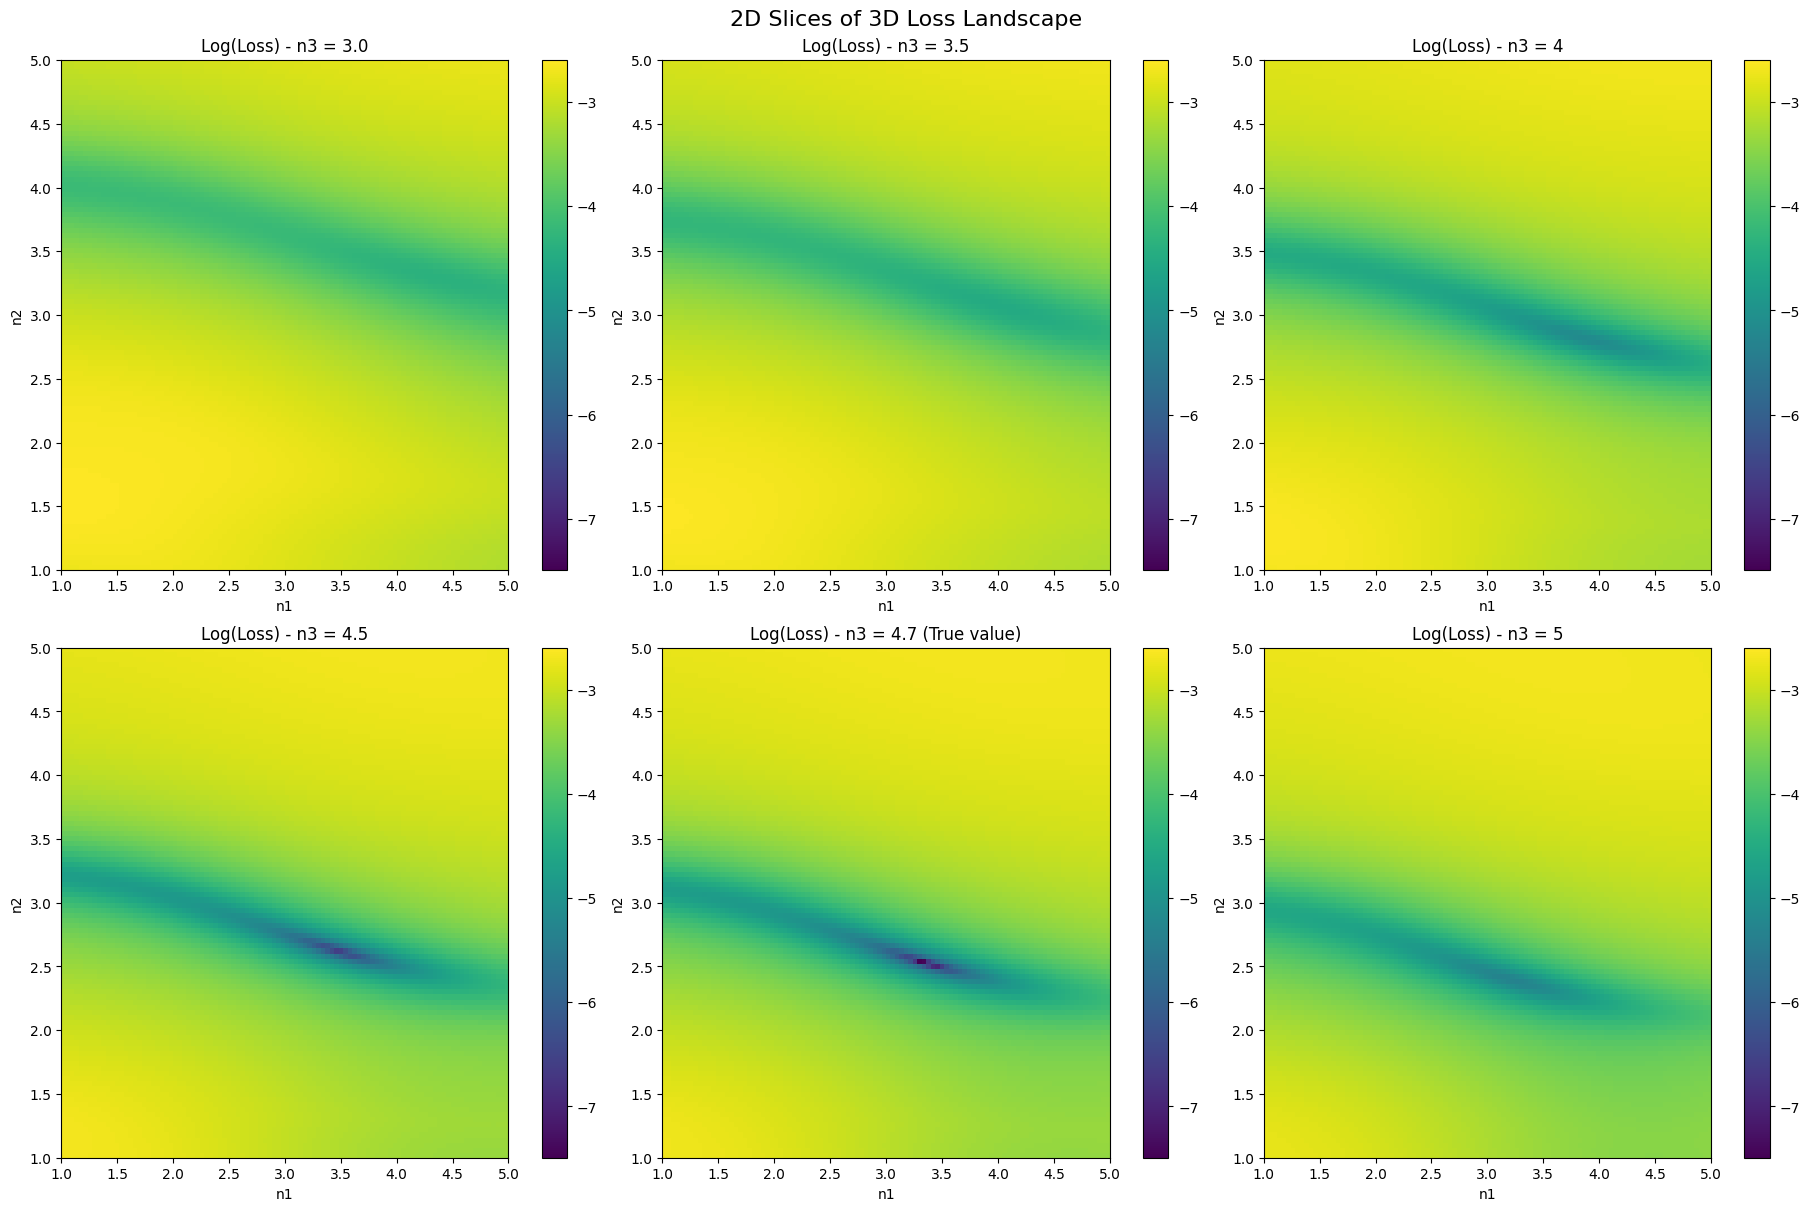

In [11]:
# Fix n3 and explore (n1, n2) space
n3_fixed_values = [3.0, 3.5, 4, 4.5, 4.7, 5]
num_points_2d = 100

loss_grids = []  # To store each loss grid

n1_vals_2d = np.linspace(*n_lims, num_points_2d)
n2_vals_2d = np.linspace(*n_lims, num_points_2d)
n1_grid_2d, n2_grid_2d = np.meshgrid(n1_vals_2d, n2_vals_2d)

# First pass: compute all loss grids
for n3_fixed in n3_fixed_values:
    loss_grid_2d = np.zeros_like(n1_grid_2d)

    for i, j in tqdm(product(range(num_points_2d), repeat=2),
                    desc=f"n3={n3_fixed:.1f}", leave=False):
        n1_curr, n2_curr = n1_grid_2d[i, j], n2_grid_2d[i, j]
        
        layer = [(n1_curr + 1j * k1, d1), (n2_curr + 1j * k2, d2), (n3_fixed + 1j * k3, d3)]
        y_sim = simulate_parallel(reference_pulse, layer, deltat, noise_level=0)[1][:len(reference_pulse)]
        y_sim_tensor = y_sim.clone().detach()
        
        loss = loss_fn(y_sim_tensor, experimental_pulse).item()
        loss_grid_2d[i, j] = loss

    loss_grids.append(np.log(loss_grid_2d))

# Compute global color scale limits
all_losses_log = np.stack(loss_grids)
vmin, vmax = all_losses_log.min(), all_losses_log.max()

# Plot
fig, axs = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
axs = axs.flatten()

for idx, (n3_fixed, loss_log) in enumerate(zip(n3_fixed_values, loss_grids)):
    im = axs[idx].imshow(
        loss_log,
        extent=[n1_vals_2d[0], n1_vals_2d[-1], n2_vals_2d[0], n2_vals_2d[-1]],
        origin='lower',
        aspect='auto',
        cmap='viridis',
        vmin=vmin,
        vmax=vmax
    )
    if n3_fixed == n_values[2]:
        axs[idx].set_title(f"Log(Loss) - n3 = {n3_fixed} (True value)")
    elif n3_fixed != n_values[2]:
        axs[idx].set_title(f"Log(Loss) - n3 = {n3_fixed}")

    axs[idx].set_xlabel("n1")
    axs[idx].set_ylabel("n2")
    plt.colorbar(im, ax=axs[idx])

plt.suptitle("2D Slices of 3D Loss Landscape", fontsize=16)
plt.show()